In [189]:
# Notebook to calculate backprop for the grand loss in MTT, i.e. 'gradient of gradients'

In [190]:
import torch
import torch.nn as nn
import numpy as np
import copy
from torchviz import make_dot

In [191]:
# TODO
"""
- Do a few update steps with the same input, and see if the grand loss is decreasing
- Manually calculate the forward pass instead of using PyTorch layers (maybe...)
- Extend this to ConvNet, compare to whatever the results are when using MTT Reparam hack
- PyTorch uses AddmmBackward0 instead of MmBackward0 when using bias, check if this makes a difference
"""

'\n- Do a few update steps with the same input, and see if the grand loss is decreasing\n- Manually calculate the forward pass instead of using PyTorch layers (maybe...)\n- Extend this to ConvNet, compare to whatever the results are when using MTT Reparam hack\n- PyTorch uses AddmmBackward0 instead of MmBackward0 when using bias, check if this makes a difference\n'

In [196]:
# Calculate dw using PyTorch autograd, and then manually by calculating the forward pass using x,
# so that we can use autograd to backprop the grand loss, eventually implmenting manually

gradients = []


# Define hook function to capture incoming gradients
def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_input)


# Input batch
N = 7

# Linear layer shapes
l1 = (4, 6) # first number is x features
l2 = (6, 5)
l3 = (5, 9)
l4 = (9, 12)

# PYTORCH CONVENTIONAL SGD STEP, used to calculate dout for different layers

# Used for PyTorch, technically can turn off bias if needed
layers_truth = nn.Sequential(
    nn.Linear(*l1, bias=False),
    nn.Linear(*l2, bias=False),
    nn.Linear(*l3, bias=False),
    nn.Linear(*l4, bias=False),
)
# layers_truth = nn.Sequential(
#     nn.Linear(*l1),
#     nn.Linear(*l2),
#     nn.Linear(*l3),
#     nn.Linear(*l4),
# )

# Used for grand loss. This deep copy is independent of the one used by PyTorch
layers_copy = copy.deepcopy(layers_truth)

# Save incoming gradients of PyTorch model Linear Layers
for layer in layers_truth:
    layer.register_full_backward_hook(save_gradients)

x = torch.randn(N, l1[0])  # Does not have a grad until we do grand loss
out = layers_truth(x)  # Forward Pass PyTorch
out.retain_grad()  # Retain incoming gradient of last Linear layer
# Imaginary target values. Must be type torch.long for CE function
target = torch.empty(N, dtype=torch.long).random_(
    layers_truth[-1].weight.shape[1]
)
loss_fn = nn.CrossEntropyLoss()
loss_sgd = loss_fn(out, target)
loss_sgd.backward(retain_graph=True)

# Ensure that no x gradients have been calculated so far
# or they will interfere with grand loss backprop
assert x.grad == None

# We only copy dw and not db because it is a function of x
# We detach them so that they are not part of a computational graph during autograd
# On FPGA, these will simply be stored in memory
grad_truth = {
    "l1_dw": layers_truth[0].weight.grad.detach().clone(),
    "l2_dw": layers_truth[1].weight.grad.detach().clone(),
    "l3_dw": layers_truth[2].weight.grad.detach().clone(),
    "l4_dw": layers_truth[3].weight.grad.detach().clone(),
    "l4_dout": out.grad.detach().clone(),  # Special case
    "l3_dout": gradients[0][0].detach().clone(),
    "l2_dout": gradients[1][0].detach().clone(),
    "l1_dout": gradients[2][0].detach().clone(),
}

# Now let us perform SGD using built in PyTorch functionality
# optimizer = torch.optim.SGD(
#     [l.weight for l in layers_truth] + [l.bias for l in layers_truth], lr=0.1
# )
optimizer = torch.optim.SGD([l.weight for l in layers_truth], lr=0.1) # No bias
optimizer.step()

# Grad truths are supposed to be constants, because douts are not functions of x
# and the dw are only used for verification
for key, val in grad_truth.items():
    assert val.is_leaf, f"{key} is not a leaf, but should be"
    # print(f"{key} is leaf: {val.is_leaf}")

# END OF PYTORCH TRUTH

# Now we begin to calculate backprop for grand loss

x.requires_grad_(True)  # Now we want to calculate gradient of x

"""
This is a very important step for making life easier:
- We only use the weight tensors, we don't need to backprop
to update their values (i.e. compute gradients)
- Hence we explicitly don't compute their gradients during back prop,
this makes the visualization graph A LOT easier to understand
"""
for idx, l in enumerate(layers_copy):
    assert l.weight.grad == None
    l.weight.requires_grad_(False)
    # l.bias.requires_grad_(False)
    # Check layer copy is not same as layer truth after SGD
    assert not torch.allclose(l.weight, layers_truth[idx].weight)

# # Now we manually calculate the dw so we can perform backprop to find x
# # Remember, for Linear layer, dw = dout.T @ input
grad_val = {
    "l1_dw": grad_truth["l1_dout"].T @ x,
    "l2_dw": grad_truth["l2_dout"].T @ layers_copy[0:1](x),
    "l3_dw": grad_truth["l3_dout"].T @ layers_copy[0:2](x),
    "l4_dw": grad_truth["l4_dout"].T @ layers_copy[0:3](x),
}  # MmBackward0

# Ensure that all of these gradients require gradient calculations
for grad in grad_val.values():
    assert grad.requires_grad
    # print(grad.requires_grad)

# Ensure calculated gradients match PyTorch
assert torch.allclose(grad_val["l1_dw"], grad_truth["l1_dw"])
assert torch.allclose(grad_val["l2_dw"], grad_truth["l2_dw"])
assert torch.allclose(grad_val["l3_dw"], grad_truth["l3_dw"])
assert torch.allclose(grad_val["l4_dw"], grad_truth["l4_dw"])

# No dw are leaves, because they are all functions of x
for key, val in grad_val.items():
    assert not val.is_leaf
    # print(f"{key} is leaf: {val.is_leaf}")

# # # # Tuples for each layer, ignoring bias again since not function of x
# # parameters_val = [l.weight.detach().clone() for l in layers]

# Now do SGD manually to ensure correct behaviour and compare to PyTorch SGD
# These are the updated weight matrices for each Linear layer
layers_val = []
for idx, layer in enumerate(layers_copy):
    # Updated parameters with knowledge of x
    # SubBackward0, MulBackward0
    layers_val.append(layer.weight - 0.1 * grad_val[f"l{idx + 1}_dw"])
    assert torch.allclose(layers_val[idx], layers_truth[idx].weight)

# Now we flatten all the parameters, to calculate grand loss
# CatBackward0, ViewBackward0
p_stacked = torch.cat([p.reshape(-1) for p in layers_val]).requires_grad_(True)

# Imaginary target values. In MTT, these correspond to the start and end expert parameters
exp_end = torch.randn(p_stacked.shape[0])  # Expert end parameters
exp_start = torch.randn(p_stacked.shape[0])  # Expert end parameters

param_loss_fn = nn.MSELoss(reduction="sum")  # Unnormalized, just like MTT
param_dist_fn = nn.MSELoss(reduction="sum")  # Unnormalized, just like MTT

param_loss = param_loss_fn(p_stacked, exp_end)  # MseLossBackward0
param_loss /= p_stacked.shape[0]
param_dist = param_dist_fn(exp_start, exp_end)  # Normalization factor
param_dist /= p_stacked.shape[0]

loss_grand = param_loss / param_dist

assert x.grad == None  # No gradient calculated for x yet
loss_grand.backward(retain_graph=True)  # Now we do backprop
print(x.shape)
print(x.grad)  # Now x has a gradient, we are done!

torch.Size([7, 4])
tensor([[ 2.6042e-05,  8.5246e-05,  3.7527e-05, -1.3163e-05],
        [ 3.6706e-05, -5.1563e-05,  5.9221e-05, -8.4895e-05],
        [ 3.8470e-05, -5.1007e-05,  6.2216e-05, -8.8726e-05],
        [ 2.6733e-06, -4.2457e-06, -6.5522e-05,  1.1876e-05],
        [-8.5725e-06,  3.4710e-05, -1.8560e-05,  2.8542e-05],
        [ 1.0543e-05, -6.5004e-05, -7.1714e-05,  1.2100e-05],
        [ 2.9268e-06, -5.5980e-06, -7.0991e-05,  1.3628e-05]])


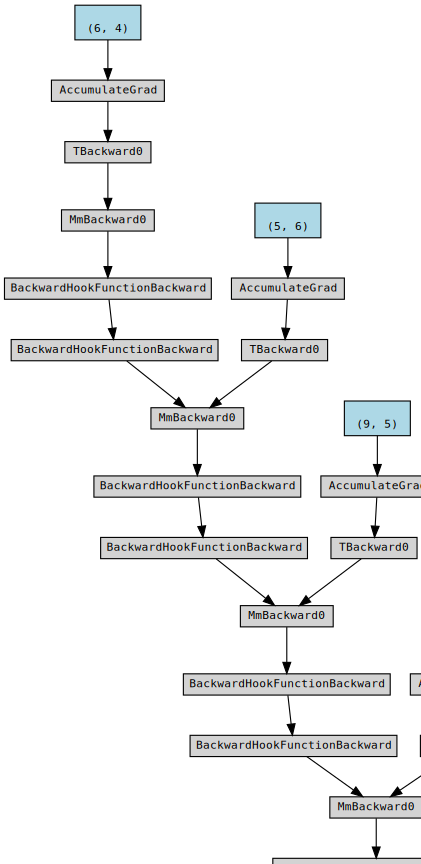

In [193]:
# Graph the Conventional network. This is not very interesting

graph = make_dot(loss_sgd)
graph.render("img/loss_sgd", format="png") # Img may be cut off, hence save to a file
graph

torch.Size([7, 4])


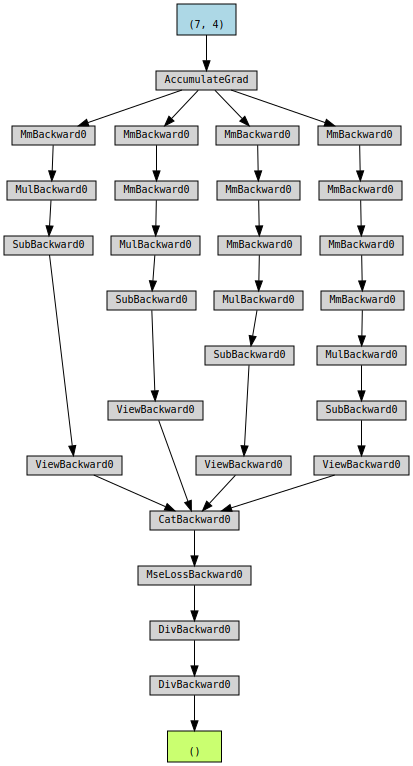

In [198]:

"""
Graph is a bit full, but actually the important things are quite simple to see

- x is the network input, the blue box (7,4) (Batch, x features). We are trying to calculate its gradient w.r.t the grand loss
- MmBackward0 is matrix multiplication, it corresponds to the calculations of dw for each layer,
i.e. dw = dout.T @ z, where dout is incoming gradient and z is layer input.
- Depending on the layer the dw is in, dout must pass through other linear layers, hence
there are 1-4 MmBackward0 depending on the dw in question (Check this is correct!)
- SubBackward0 and MulBackward0 are from the manual SGD step we calculated
- ViewBackward0 and CatBackward0 are from the concatenation in the final steps of grand loss
- MSELoss is self explanatory, DivBackward0 is just the normalization done by MTT

A closer look shows that this is just a sum of backpropagations, where each path is simply one layer deeper
In other words, this is very doable with simple DNN layers.
Also, because the dout have been precomputed, this is probably quite fast if we do it all in parallel.
"""

# Graph the Network for grand loss calculation
# x is blue box with following dimensions:
print(x.shape)

# graph = make_dot(loss_grand, show_attrs=True) # Verbose, requires retaining graph
graph = make_dot(loss_grand)
graph.render(
    "img/loss_grand", format="png"
)  # Img may be cut off, hence save to a file
graph


In [ ]:
# # First we test using only linear layers

# # Linear layers y = xWT + b

# # Layer 1
# in_dim = (5, 4)
# out_dim = 7
# x1 = torch.rand(*in_dim, requires_grad=True)
# WT1 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b1 = torch.randn(out_dim, requires_grad=True)
# y1 = x1 @ WT1 + b1
# y1.retain_grad()
# # print(y1.shape)

# # Layer 2
# in_dim = y1.shape
# out_dim = 4
# WT2 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b2 = torch.randn(out_dim, requires_grad=True)
# y2 = y1 @ WT2 + b2
# y2.retain_grad()
# # print(y2.shape)

# # Layer 3
# in_dim = y2.shape
# out_dim = 3
# WT3 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b3 = torch.randn(out_dim, requires_grad=True)
# out = y2 @ WT3 + b3
# out.retain_grad() # Output of network

# # Sanity check
# # print(out == (((x1 @ WT1 + b1) @ WT2 + b2)) @ WT3 + b3)

# # Loss
# target = torch.randn(out.shape)
# loss_fn = nn.MSELoss()
# output = loss_fn(out, target)
# output.retain_grad()
# output.backward()

# dout_val = 2 * (out - target) / np.prod(out.shape) # derivative of MSELoss
# dx1_val = 0

# # print(dout_val)
# # print(out.grad)




In [ ]:
# Only tensors that are not computed from other tensors are leaves.
# This tells us that all weight and bias tensors are leaves initally.
# for var in [x1, y2, out, WT1, WT2, WT3, b1, b2, b3]:
#     print(var.is_leaf)

# print(WT1)
# print(WT1.grad)

# optimizer = torch.optim.SGD([WT1, WT2, WT3, b1, b2, b3], lr=0.1)
# # Perform one step of SGD
# optimizer.step()

# # WT1 has now been updated, but is still a leaf (no dependencies!)
# print(WT1)

# p_stacked = torch.cat[]

In [ ]:
# # Calculating the grand loss as described in MTT

# # First flatten and concatenate all the parameters
# # parameters = [
# #     WT1.detach().clone(),
# #     WT2.detach().clone(),
# #     WT3.detach().clone(),
# #     b1.detach().clone(),
# #     b2.detach().clone(),
# #     b3.detach().clone(),
# # ]
# parameters = [
#     WT1,
#     WT2,
#     WT3,
#     b1,
#     b2,
#     b3,
# ]

# # All the parameters should be leaves because they don't have dependencies
# # for var in parameters:
# #     print(var.is_leaf)
# p_stacked = torch.cat([p.reshape(-1) for p in parameters]).requires_grad_(True)
# # p_stacked.retain_grad()
# # Sanity check
# num_param = sum(np.prod(p.shape) for p in parameters)
# print(p_stacked.shape[0] == num_param)

# # # Imaginary start and end expert parameters
# # exp_start_stacked = torch.randn(p_stacked.shape)
# # exp_end_stacked = torch.randn(p_stacked.shape)

# # param_loss_mse = nn.MSELoss(reduction='sum')
# # param_dist_mse = nn.MSELoss(reduction='sum')

# # param_loss = param_loss_mse(p_stacked, exp_end_stacked)
# # param_loss /= num_param
# # param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# # param_dist /= num_param

# # grand_loss = param_loss / param_dist

# # print(grand_loss)
# # print(WT1.grad)
# # print(p_stacked.grad)
# # grand_loss.backward()
# # print(p_stacked.grad)
# # print(WT1.grad)

# # Let us compare this to a manual calculation of the gradients, by using the forward pass

# # Do for the variable WT1



In [ ]:
# # First we test using only linear layers

# # Linear layers y = xWT + b

# # Layer 1
# in_dim = (9, 4)
# out_dim = 7
# x1 = torch.rand(*in_dim, requires_grad=True)
# WT1 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b1 = torch.randn(out_dim, requires_grad=True)
# y1 = x1 @ WT1 + b1
# y1.retain_grad()

# # Layer 2
# in_dim = y1.shape
# out_dim = 4
# WT2 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b2 = torch.randn(out_dim, requires_grad=True)
# y2 = y1 @ WT2 + b2
# y2.retain_grad()

# # Layer 3
# in_dim = y2.shape
# out_dim = 3
# WT3 = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b3 = torch.randn(out_dim, requires_grad=True)
# out = y2 @ WT3 + b3
# out.retain_grad() # Output of network

# # Sanity check
# # print(out == (((x1 @ WT1 + b1) @ WT2 + b2)) @ WT3 + b3)

# # output.retain_grad()
# # output.backward()

# # dout_val = 2 * (out - target) / np.prod(out.shape) # derivative of MSELoss
# # dx1_val = 0

# # # Sanity check
# # print(torch.allclose(dout_val, out.grad))

# # First flatten and concatenate all the parameters. These can be considered references,
# # not copies, so they retain their computational graphs if used.
# student_parameters = {
#     "WT1": WT1,
#     "WT2" : WT2,
#     "WT3" : WT3,
#     "b1" : b1,
#     "b2" : b2,
#     "b3" : b3,
#     "x1": x1,
#     # "y1" : y1,
#     # "y2" : y2
# }
# # All the parameters should be leaves because they don't have dependencies
# # for var in student_parameters.values():
# #     print(var.is_leaf)
# p_stacked = torch.cat([p.reshape(-1) for p in student_parameters.values()]).requires_grad_(True)

# # # Sanity check
# num_param = sum(np.prod(p.shape) for p in student_parameters.values())
# # print(p_stacked.shape[0] == num_param)

# # # Calculate the traditional loss, however instead of using backward method, we use autograd manually
# # # In this way, the grad attributes of each parameter is not populated, and we can use them
# # # to instead compute the grand loss.
# target = torch.empty(out.shape[0], dtype=torch.long).random_(
#     out.shape[1]
# )  # Imaginary target values. Must be type torch.long for CE function
# loss_fn = nn.CrossEntropyLoss()
# output = loss_fn(out, target)
# grad = torch.autograd.grad(outputs=output, inputs=student_parameters.values(), create_graph=True)
# grad_stacked = torch.cat([p.reshape(-1) for p in grad]).requires_grad_(True)
# grad_descent = p_stacked - 0.1 * grad_stacked

# # Sanity check (comment out when computing grand loss!)
# # output.backward()
# # print(parameters[0].grad)
# # print(WT1.grad)
# # WT1.grad[0] += 1
# # print(parameters[0].grad)
# # print(WT1.grad)

# # Imaginary start and end expert parameters
# exp_start_stacked = torch.randn(p_stacked.shape)
# exp_end_stacked = torch.randn(p_stacked.shape)

# param_loss_mse = nn.MSELoss(reduction='sum')
# param_dist_mse = nn.MSELoss(reduction='sum')

# param_loss = param_loss_mse(grad_descent, exp_end_stacked)
# param_loss /= num_param
# param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# param_dist /= num_param

# grand_loss = param_loss / param_dist
# # grand_loss = param_loss
# print(grand_loss)
# grand_loss.backward()
# _ = 0

# # Not sure how the loss back propagates, hence will rewrite using PyTorch layers


In [ ]:
# print(x1.grad)

# print()

In [ ]:
# from torchviz import make_dot

# graph = make_dot(grand_loss, params=student_parameters)

# graph

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# import os

# # Batch
# N = 7

# # Linear layer shapes
# l1 = (4, 6)
# l2 = (6, 5)
# l3 = (5, 9)

# layers = nn.Sequential(
#     nn.Linear(*l1), nn.Linear(*l2), nn.Linear(*l3)
# )

# parameters = [
#     layers[0].weight,
#     layers[1].weight,
#     layers[2].weight
# ]

# # All the parameters should be leaves because they don't have dependencies
# # for var in parameters:
# #     print(var.is_leaf)
# p_stacked = torch.cat([p.reshape(-1) for p in parameters]).requires_grad_(True)

# # Calculate the traditional loss, however instead of using backward method, we use autograd manually
# # In this way, the grad attributes of each parameter is not populated, and we can use them
# # to instead compute the grand loss.
# x = torch.randn(N, l1[0])
# out = layers(x)
# target = torch.empty(N, dtype=torch.long).random_(
#     l3[1]
# )  # Imaginary target values. Must be type torch.long for CE function
# loss_fn = nn.CrossEntropyLoss()
# output = loss_fn(out, target)
# grad = torch.autograd.grad(outputs=output, inputs=parameters, create_graph=True)
# grad_stacked = torch.cat([p.reshape(-1) for p in parameters]).requires_grad_(True)
# grad_descent = p_stacked - 0.1 * grad_stacked

# # Imaginary start and end expert parameters
# exp_start_stacked = torch.randn(p_stacked.shape)
# exp_end_stacked = torch.randn(p_stacked.shape)

# param_loss_mse = nn.MSELoss(reduction='sum')
# param_dist_mse = nn.MSELoss(reduction='sum')

# param_loss = param_loss_mse(grad_descent, exp_end_stacked)
# param_loss /= num_param
# # param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# # param_dist /= num_param

# # # TensorBoard
# # log_path = os.path.join("testing")
# # tb_logger = SummaryWriter(log_path)

# # tb_logger.add_graph(
# #     layers,
# #     torch.randn(7, 4)
# # )


In [ ]:
# # Lets instead try to do everything with just a single layer, to understand what is going on

# # Layer 1
# in_dim = (9, 4)
# out_dim = 7
# x = torch.rand(*in_dim, requires_grad=True)
# WT = torch.rand(in_dim[-1], out_dim, requires_grad=True)
# b = torch.randn(out_dim, requires_grad=True)
# out = x @ WT + b
# out.retain_grad()

# parameters = {
#     # "x" : x,
#     "WT" : WT,
#     "b" : b
# }

# p_stacked = torch.cat([p.reshape(-1) for p in parameters.values()]).requires_grad_(True)

# # # Sanity check
# num_param = sum(np.prod(p.shape) for p in parameters.values())
# # print(p_stacked.shape[0] == num_param)

# target = torch.empty(out.shape[0], dtype=torch.long).random_(
#     out.shape[1]
# )  # Imaginary target values. Must be type torch.long for CE function
# loss_fn = nn.CrossEntropyLoss()
# output = loss_fn(out, target)
# # output.retain_grad()
# # output.backward()

# # print(output.grad)
# grad = torch.autograd.grad(outputs=output, inputs=parameters.values(), create_graph=True)
# print(out.grad)
# # grad_stacked = torch.cat([p.reshape(-1) for p in grad]).requires_grad_(True)
# # grad_descent = p_stacked - 0.1 * grad_stacked

# # # Imaginary start and end expert parameters
# # exp_start_stacked = torch.randn(p_stacked.shape)
# # exp_end_stacked = torch.randn(p_stacked.shape)

# # param_loss_mse = nn.MSELoss(reduction='sum')
# # param_dist_mse = nn.MSELoss(reduction='sum')

# # param_loss = param_loss_mse(grad_descent, exp_end_stacked)
# # param_loss /= num_param
# # param_dist = param_dist_mse(exp_start_stacked, exp_end_stacked)
# # param_dist /= num_param

# # grand_loss = param_loss / param_dist
# # # grand_loss = param_loss
# # print(grand_loss)
# # grand_loss.backward()

# # print(output.grad)



In [ ]:
# print(x.grad)
# # print(out.grad)
# # print(WT.grad)
# print((out.grad @ WT.T))

In [ ]:
# from torchviz import make_dot

# graph = make_dot(grand_loss, params=parameters)

# graph

In [ ]:
# # Show the Forward Graph (used for conventional SGD)

# graph = make_dot(output)
# graph.render("attached", format="png")


In [ ]:
# print(layers[0].weight)
# print(parameters_val[0])